In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

In [2]:
# rmse optimization
# decomp based optimization

# data

[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4.
  4. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 7. 7. 7. 7. 7. 8. 8. 8. 8. 8. 9. 9. 9.
  9. 9.]]


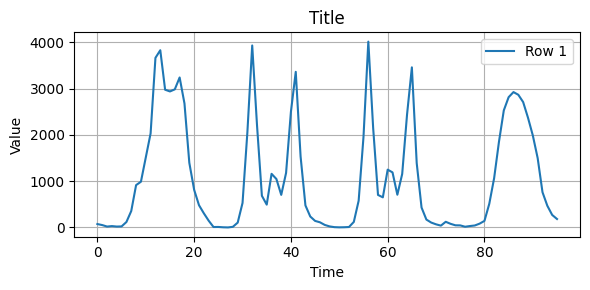

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from patrec.utils.files_helper import Format1_loader
from patrec.utils.visuals import plot_series, plot_series_grid

from sklearn.metrics import mean_squared_error

EXP_PATH = Path('.temp/STL_decomp/')
# DATASET_NAME = 'AbnormalHeartbeat'
DATASET_NAME = 'MelbournePedestrian' 
# DATASET_NAME = 'MelbournePedestrian' 

npy_dict = {
    'data':f'data/sub_UCR_bench/{DATASET_NAME}/sample_2/X_train.npy',
    'labels':f'data/sub_UCR_bench/{DATASET_NAME}/sample_2/y_train.npy',
    'meta':None
}

loader = Format1_loader(npy_files=npy_dict)
loader.data = np.asarray([item[0] for item in loader.data])

DATASET_PATH = EXP_PATH/'data/dt.json'

print(loader.labels.reshape(1,-1))
# loader.to_json(DATASET_PATH)

data = loader.data

# row0 = loader.data[0]
# plot_series(row0, figsize=(6,3))

# row0_me = pd.DataFrame({'data':loader.data[0]}, index=pd.date_range(start="2020-01-01", periods=len(loader.data[0]), freq='D')).resample('ME').mean().ffill()

# plot_series(row0_me.values)

row1 = np.concatenate([loader.data[4], loader.data[5], loader.data[6], loader.data[1]], axis=0)
plot_series(row1, figsize=(6,3))


In [4]:
from statsmodels.datasets import co2
data = co2.load().data#.ffill()
# data.shape
data1 = data.resample('ME').mean().ffill()[:50]
data2 = data.resample('ME').mean().ffill()[50:100]
data = data.resample('ME').mean().ffill()

## synthetic_data

In [36]:
from patrec.generation import linear_trend, sin_wave

def generate_nested_seasonality(
    seasonality_windows=None,
    amplitude_list=None,
    trend_slope=0.001,
    noise_level=1.0,
    length=1000,
    seed=None
):
    """
    Generator function to yield one time step of synthetic time series per call.
    
    Args:
        seasonality_windows: List of periods (in steps) for each seasonal component.
        amplitude_list: Amplitudes corresponding to each window.
        trend_slope: Slope of the linear trend.
        noise_level: Standard deviation of random Gaussian noise.
        length: Total number of steps to generate.
        seed: Optional random seed for reproducibility.
    """
    if seasonality_windows is None:
        seasonality_windows = [24, 168]  # default: daily and weekly (24h, 7*24h)
    if amplitude_list is None:
        amplitude_list = [5.0, 10.0]  # default amplitudes

    assert len(seasonality_windows) == len(amplitude_list), "Each seasonality window must have a matching amplitude."

    np.random.seed(seed)

    # Precompute full-length components
    t = np.arange(length)
    trend = linear_trend(trend_slope, length)
    noise = np.random.normal(0, noise_level, length)

    # Generate all sinusoids
    sinusoids = []
    for window, amp in zip(seasonality_windows, amplitude_list):
        # freq = int(length/window)
        sinusoid = sin_wave(amplitude=amp, frequency=window, phase=0, length=length)
        sinusoids.append(sinusoid)

    # Combine all components
    total_signal = trend + noise + sum(sinusoids)

    # Yield one value at a time
    for i in range(length):
        yield total_signal[i]
        

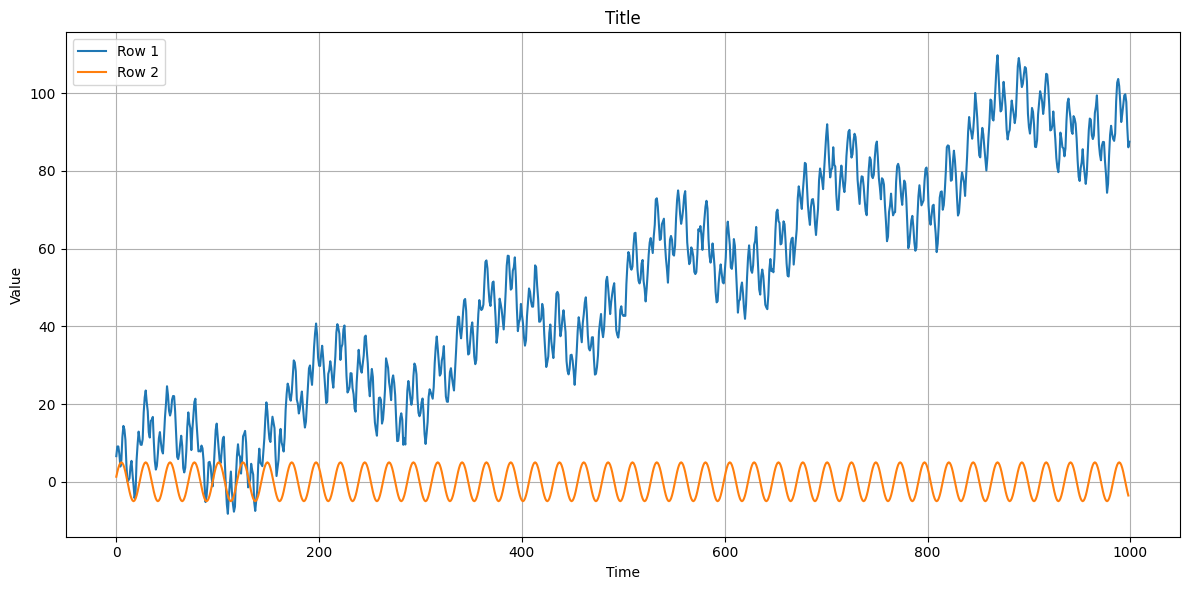

In [37]:
# Create the generator object
gen = generate_nested_seasonality(
    seasonality_windows=[7, 24, 168],
    amplitude_list=[5, 7, 10],
    trend_slope=0.1,
    noise_level=1,
    length=1000,
    seed=42
)
# amplitude * np.sin(2 * np.pi * frequency * x + phase)

t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))

synth_row1 = np.asarray(list(gen))
# synth_row1.shape

plot_series([synth_row1, daily_seasonality])

In [6]:
# Create the generator object
gen = generate_nested_seasonality(
    seasonality_windows=[7, 24, 168],
    amplitude_list=[5, 7, 10],
    trend_slope=0.1,
    noise_level=1,
    length=1000,
    seed=42
)
# amplitude * np.sin(2 * np.pi * frequency * x + phase)

t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))

synth_row1 = np.asarray(list(gen))

# Stats methods

## params init

In [6]:
from patrec.utils import YAML_Config, JSON_Handler, Format1_loader

In [7]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL

params = {
    'period': 20, 
    'trend_deg': 1, 
    'seasonal_deg': 1,
    'robust': True
}

stl_params = YAML_Config(data=params)
stl_params.save('patrec/feature_extraction/stats_methods/configs/default_stl_config.yaml')

In [8]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.MSTL.html#statsmodels.tsa.seasonal.MSTL

params = {
    'periods': [4, 7, 12, 24, 24*7], 
    'windows': None
}

mstl_params = YAML_Config(data=params)
mstl_params.save('patrec/feature_extraction/stats_methods/configs/default_mstl_config.yaml')

In [9]:
# gen params 
# 
meta_gen_dt1 = [
    YAML_Config(data={'seasonality_windows':[4], 'amplitude_list':[2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[7], 'amplitude_list':[2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[12], 'amplitude_list':[2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[24], 'amplitude_list':[2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[4, 24], 'amplitude_list':[2,2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[7, 24], 'amplitude_list':[2,2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[12, 24], 'amplitude_list':[2,2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25}),
    YAML_Config(data={'seasonality_windows':[36, 72], 'amplitude_list':[2,2], 'trend_slope':0.01, 'noise_level':0., 'length':500, 'seed':25})
]

data_gen_dt1 = [list(generate_nested_seasonality(**meta.data)) for meta in meta_gen_dt1]

labels_gen_dt1 = [meta.data['seasonality_windows'] for meta in meta_gen_dt1]

gen_dt1 = JSON_Handler(data={'data':data_gen_dt1, 'labels':labels_gen_dt1, 'meta':meta_gen_dt1}, filepath='data/Synthetic_data/several_periods/gen_dt1.json')

save data to data/Synthetic_data/several_periods/gen_dt1.json


In [10]:
# dt1 = JSON_Handler(filepath='data/Synthetic_data/several_periods/gen_dt1.json')
# plot_series([dt1.data['data'][1]])

## tests

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import linregress
import numpy as np
from typing import Tuple, Dict, Union
import warnings
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

def get_hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    
    return np.polyfit(np.log(lags), np.log(tau), 1)[0].round(4)

def hurst_exponent(ts, lags=None, weights=None):
    """
    Mean hurst
    """    
    if not lags:
        lags = np.asarray([20, 100, 200, 500, 1000])
        lags = lags[lags < len(ts)]

    if not weights:
        weights = [1/(len(lags)+1) if i >= 2 else 1/len(lags) for i in range(len(lags))]

    hurst_est = []
    
    for lag in lags:
        hurst_est.append(get_hurst_exponent(ts, lag))
    
    return np.mean(hurst_est).round(4), {'lags':lags, 'weights':weights, 'hurst_est':hurst_est}

def test_stationarity(ts: np.ndarray, alpha: float = 0.05) -> Tuple[bool, Dict[str, Union[float, str]]]:
    """
    Test time series stationarity using ADF, KPSS, and Hurst exponent.
    
    Args:
        ts: Time series data.
        alpha: Significance level (default: 0.05).
    
    Returns:
        Tuple of:
        - is_stationary (bool): True if series is likely stationary.
        - results (dict): Test statistics and interpretations.
    """
    # ADF Test (Null: Non-stationary)
    adf_result = adfuller(ts)
    adf_p = adf_result[1]
    adf_reject_null = adf_p <= alpha
    
    # KPSS Test (Null: Stationary)
    kpss_result = kpss(ts, regression='c')  # 'c' for constant, 'ct' for trend
    kpss_p = kpss_result[1]
    kpss_reject_null = kpss_p <= alpha
    
    # Hurst Exponent
    hurst, hurst_est = hurst_exponent(ts)
    hurst_behavior = (
        "Random Walk (H ≈ 0.5)" if 0.45 <= hurst <= 0.55 else
        "Mean-Reverting (H < 0.5)" if hurst < 0.45 else
        "Trending (H > 0.5)"
    )
    
    # Combined Decision Logic
    is_stationary = (
        (not kpss_reject_null) and  
        (adf_reject_null) and       
        (hurst < 0.5)               
    )
    
    return is_stationary, {
        "ADF Test": {
            "p-value": adf_p,
            "test_result": "Stationary" if adf_reject_null else "Non-Stationary",
        },
        "KPSS Test": {
            "p-value": kpss_p,
            "test_result": "Non-Stationary" if kpss_reject_null else "Stationary",
        },
        "Hurst Exponent": {
            "value": hurst,
            "test_result": hurst_behavior,
        },
        "combined_result": "Stationary" if is_stationary else "Non-Stationary",
    }


Random Walk Results:
{'ADF Test': {'p-value': 0.7654789696692577, 'test_result': 'Non-Stationary'}, 'KPSS Test': {'p-value': 0.01, 'test_result': 'Non-Stationary'}, 'Hurst Exponent': {'value': 0.4669, 'test_result': 'Random Walk (H ≈ 0.5)'}, 'combined_result': 'Non-Stationary'}

Stationary Series Results:
{'ADF Test': {'p-value': 0.0, 'test_result': 'Stationary'}, 'KPSS Test': {'p-value': 0.1, 'test_result': 'Stationary'}, 'Hurst Exponent': {'value': 0.0004, 'test_result': 'Mean-Reverting (H < 0.5)'}, 'combined_result': 'Stationary'}

Row1 Series Results:
{'ADF Test': {'p-value': 2.2589552870006036e-05, 'test_result': 'Stationary'}, 'KPSS Test': {'p-value': 0.1, 'test_result': 'Stationary'}, 'Hurst Exponent': {'value': 0.1415, 'test_result': 'Mean-Reverting (H < 0.5)'}, 'combined_result': 'Stationary'}

Synth_row1 Series Results:
{'ADF Test': {'p-value': 0.8697956507141239, 'test_result': 'Non-Stationary'}, 'KPSS Test': {'p-value': 0.01, 'test_result': 'Non-Stationary'}, 'Hurst Exponen

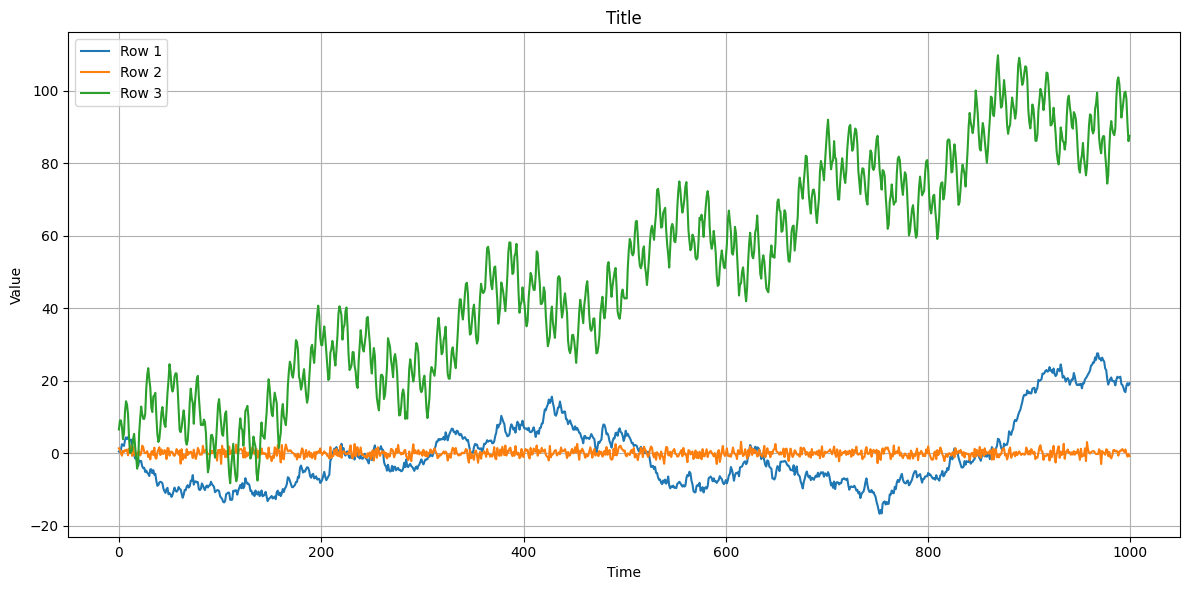

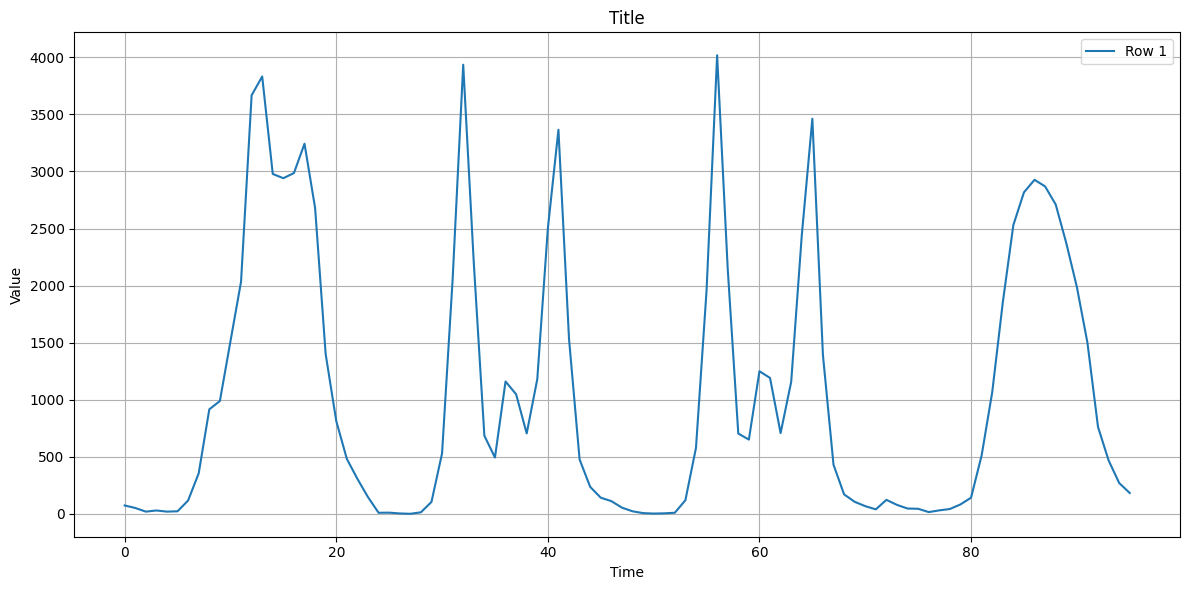

In [38]:
np.random.seed(42)

random_walk = np.cumsum(np.random.randn(1000))
is_stationary, results = test_stationarity(random_walk)
print("Random Walk Results:")
print(results)

stationary_series = np.random.randn(1000)
is_stationary, results = test_stationarity(stationary_series)
print("\nStationary Series Results:")
print(results)

is_stationary, results = test_stationarity(row1)
print("\nRow1 Series Results:")
print(results)

is_stationary, results = test_stationarity(synth_row1)
print("\nSynth_row1 Series Results:")
print(results)

plot_series([random_walk, stationary_series, synth_row1])
plot_series([row1])

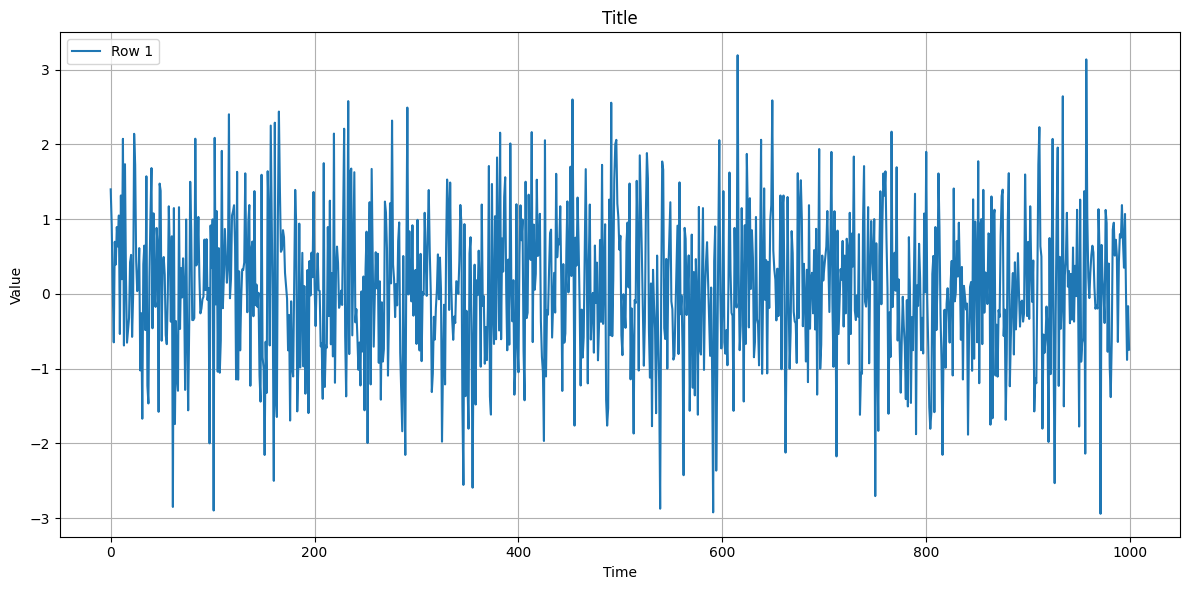

Kendall's Tau: -0.017, p-value: 0.413
No significant trend.


In [ ]:
# может быть использовать для результатов декомпозиции
from scipy.stats import kendalltau

# Generate example data
np.random.seed(42)
y = np.cumsum(np.random.randn(100))  # Random walk with trend

import ruptures as rpt

n, dim = 500, 1
n_bkps, sigma = 3, 1
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# Mann-Kendall test
# tau, p_value = kendalltau(np.arange(len(signal)), signal)
# plot_series([signal])
# tau, p_value = kendalltau(np.arange(len(y)), y)
# plot_series([y])
tau, p_value = kendalltau(np.arange(len(stationary_series)), stationary_series)
plot_series([stationary_series])

print(f"Kendall's Tau: {tau:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Significant trend detected!")
else:
    print("No significant trend.")
    


Chow Test Statistic: 9.207, p-value: 0.000
Structural break detected at t=[(1, 1.63), (5, 1.36), (10, 1.22)]


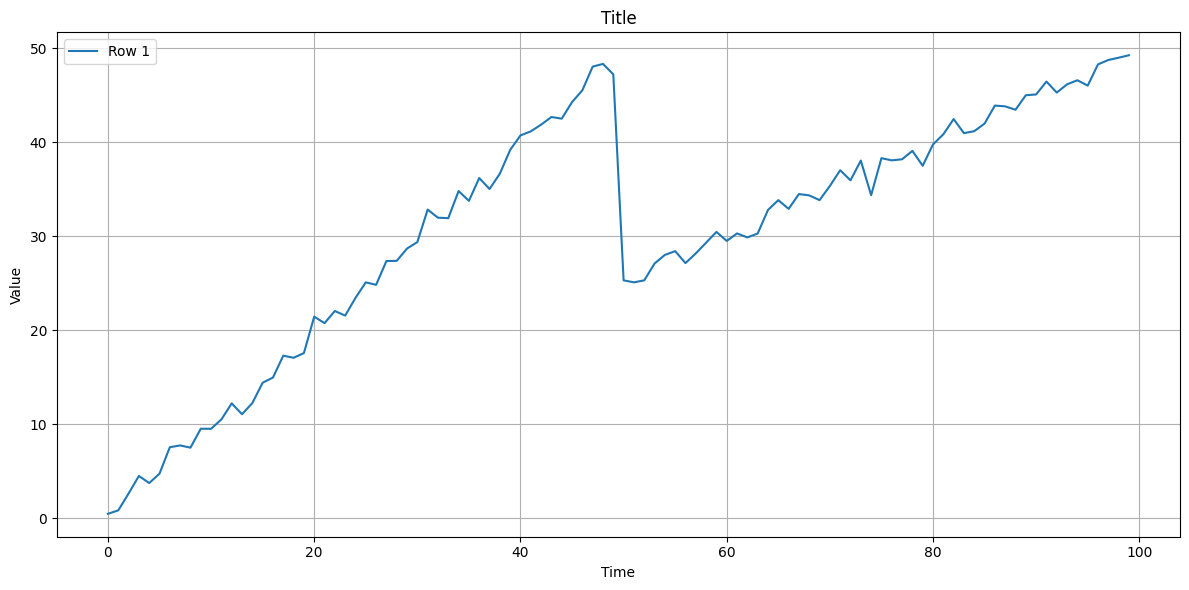

In [ ]:
# вместо mad

from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Generate data with a break at t=50
np.random.seed(42)
y = np.concatenate([
    np.arange(50) + np.random.randn(50),
    np.arange(50) * 0.5 + 25 + np.random.randn(50)
])

# Chow test (automatically detects breaks)
test_stat, p_value, breakpoint = breaks_cusumolsresid(y)

print(f"Chow Test Statistic: {test_stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print(f"Structural break detected at t={breakpoint}")
    
plot_series(y)

## methods estimation

In [13]:
default_stl_config = YAML_Config('patrec/feature_extraction/stats_methods/configs/default_stl_config.yaml').data
default_stl_config

{'period': 20, 'trend_deg': 1, 'seasonal_deg': 1, 'robust': True}

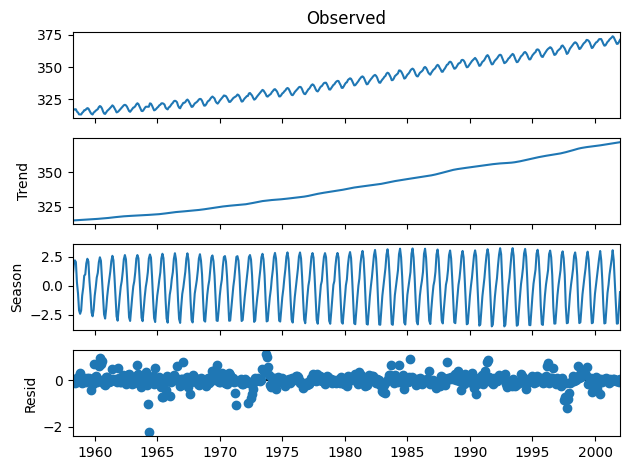

In [14]:
from statsmodels.tsa.seasonal import STL, MSTL

default_stl_config['period'] = 12

model = STL(data, **default_stl_config)
result = model.fit()
result.plot()
plt.show()

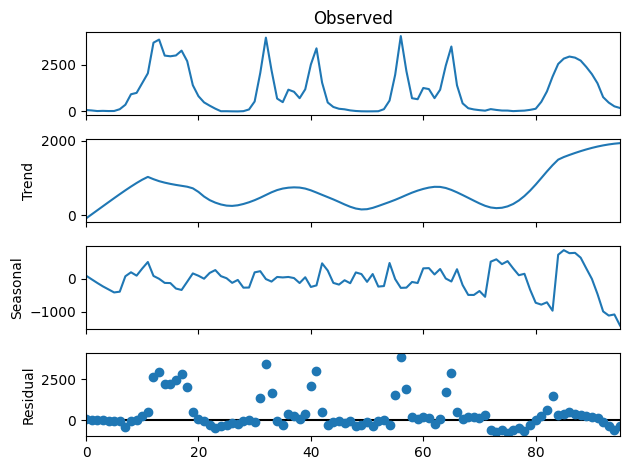

In [15]:
model = STL(endog=row1, **default_stl_config)
result = model.fit()
result.plot()
plt.show()

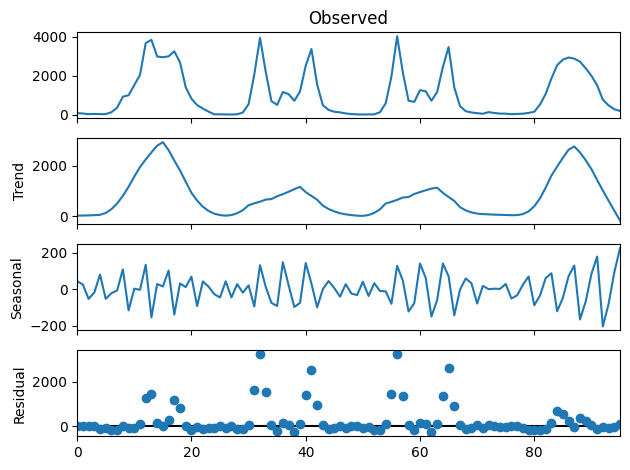

In [16]:
default_stl_config['period'] = 4

model = STL(endog=row1, **default_stl_config)
result = model.fit()
result.plot()
plt.show()

In [17]:
default_mstl_config = YAML_Config('patrec/feature_extraction/stats_methods/configs/default_mstl_config.yaml').data
default_mstl_config

{'periods': [4, 7, 12, 24, 168], 'windows': None}

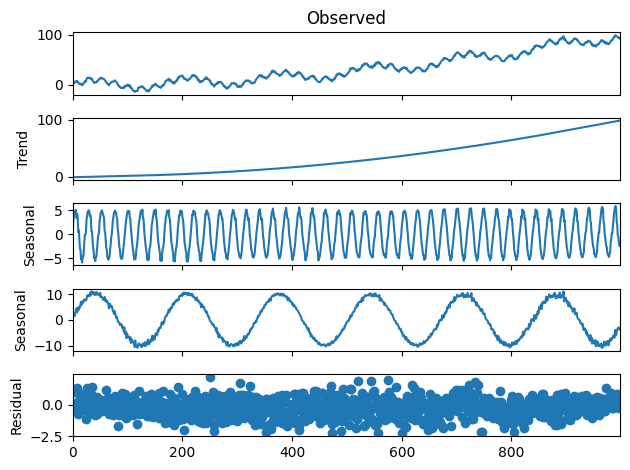

In [18]:
import pandas as pd

t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
noise = np.random.randn(len(t))
y = trend + daily_seasonality + weekly_seasonality + noise
# ts = pd.date_range(start="2020-01-01", freq="h", periods=len(t))
# df = pd.DataFrame(data=y, index=ts, columns=["y"])

default_mstl_config['periods'] = [24, 24*7]

model = MSTL(endog=y, **default_mstl_config)
result = model.fit()
fig = result.plot()
plt.show()

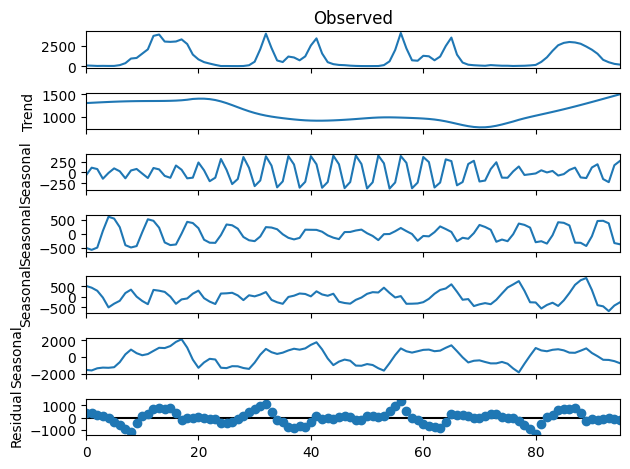

In [19]:
# params = {
#     # 'periods': [48, 48*7],
#     # 'periods': [12, 24, 24*7],
#     'periods': [24, 24*7],
#     # 'windows':[101, 101],
#     # 'iterate':3,
#     # "stl_kwargs":{
#     #             "trend":1001, # Setting this large will force the trend to be smoother.
#     #             "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
#     #            }
# }

# default_mstl_config['periods'] = [24, 24*7]
default_mstl_config['periods'] = [4, 7, 12, 24]

model = MSTL(endog=row1, **default_mstl_config)
result = model.fit()
fig = result.plot()

In [20]:
# plot_series([result.seasonal.sum(axis=1) + result.trend, -result.resid, row1]) 

## optimization

### functions

In [21]:
# seasonality and trend opt func
from typing import Literal
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import (pearsonr, spearmanr, kendalltau, 
                         pointbiserialr, weightedtau)
# from statsmodels.stats.dist_dependence_measures import distance_correlation, distance_statistics
# distance_correlation(data1, data2), distance_correlation(data1, data1)
from scipy.spatial.distance import cosine


def seasonal_correlation(result):
    """
    Estimate correlation between seasonal component and ideal signal
    Optimize: maximization
    Intervals: 
        good (0.3, 1]
        suspicious: [-0.3, 0.3]
        bad: (-0.3, -1]
        
    idea -> algo:Literal['dist', 'prototype']='dist', params:dict=None
    """
    # can be expanded with generators    
    # if params:
    
    t = params.get('t', np.arange(len(result['seasonal'])))
    seasonal_period = result.get('period', 12)
    seasonal_ampl = result.get('amplitude', 2)
    ideal_signal = np.sin(seasonal_ampl * np.pi * t / seasonal_period)

    corr, _ = pearsonr(result['seasonal'], ideal_signal)
    return corr


def seasonal_strength(result):
    """
    Estimate how greate changes in seasonal component and residuals
    Optimize: maximization
    Intervals: 
        good: [0.7, 1]
        sus: [0.3, 0.7)
        bad: [0, 0.3)
    """
    # if residuals.mean() >= 0.1:
    return max(0, 1 - np.var(result.get('resid')) / np.var(result.get('seasonal') + result.get('resid')))
    
    # return 0

# плохие результаты
# def trend_strength(trend_component, residuals):
#     """
#     Estimate how greate changes in trend component and residuals
#     Optimize: maximization
#     Intervals: 
#         good: [0.7, 1]
#         sus: [0.3, 0.7)
#         bad: [0, 0.3)
#     """
#     return max(0, 1 - np.var(residuals) / np.var(trend_component + residuals))


def find_period_range(series, strategy:Literal['mean', 'max', 'min']=None, ci_coef:int=2):
    
    if not strategy:
        peaks, _ = find_peaks(series, height=0)
        
        if len(peaks) >= 100:
            strategy = 'mean'
            print(f'applied max strategy, {len(peaks)=}')
        else:
            strategy = 'max'
            print(f'applied max strategy, {len(peaks)=}')
    
    if strategy == 'mean':
        peaks, _ = find_peaks(series, height=np.mean(series))
        return int(np.mean(peaks - np.concatenate([np.array([0]), peaks[0:]])[:-1]) * ci_coef)
    
    if strategy == 'min':
        peaks, _ = find_peaks(series, height=-np.abs(np.max(series)))
        return int(np.min(peaks - np.concatenate([np.array([0]), peaks[0:]])[:-1])) - ci_coef
    
    peaks, _ = find_peaks(series, height=np.median(series))

    return int(np.max(peaks - np.concatenate([np.array([0]), peaks[0:]])[:-1]) * ci_coef)

### process

In [22]:
default_stl_config

{'period': 4, 'trend_deg': 1, 'seasonal_deg': 1, 'robust': True}

In [23]:
# find_period_range(ts_obj, 'max')
# data.values

# p, d = find_peaks(ts_obj, height=-np.mean(ts_obj))
# len(p)

In [24]:
import optuna
import logging
# Отключаем информационные сообщения
optuna.logging.set_verbosity(optuna.logging.WARNING)

dt1 = JSON_Handler(filepath='data/Synthetic_data/several_periods/gen_dt1.json')
inx = 1
print(dt1.data['meta'][inx])
ts_obj = np.asarray(dt1.data['data'][inx])

# ts_obj = data.copy().values.reshape(-1, )

# from scipy.datasets import electrocardiogram
# ts_obj = electrocardiogram()[2000:4000]

# min_period = find_period_range(ts_obj,'mean')
min_period = find_period_range(ts_obj,'min')
max_period = find_period_range(ts_obj, None)
print(min_period, max_period)

def objective_components(trial):
    
    period = trial.suggest_int('period', min_period if min_period > 1 else 2, max_period)
    trend_deg = trial.suggest_int("trend_deg", 0, 1)
    seasonal_deg = trial.suggest_int("seasonal_deg", 0, 1)
    
    model = STL(ts_obj, period=period, trend_deg=trend_deg, seasonal_deg=seasonal_deg, robust=False)
    result = model.fit()

    return seasonal_strength({'seasonal':result.seasonal, 'resid':result.resid})
    # return seasonal_correlation(result.seasonal, params={'seasonal_period':model.period})

# для seasonal_correlation можно использовать много итераций 
# для seasonal_strength нужно использовать небольшие значения относительно реального значения period

study = optuna.create_study(direction="maximize")
study.optimize(objective_components, n_trials=200, timeout=20)

trial = study.best_trial

print("Best function value: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

# optuna.visualization.plot_optimization_history(study)
# fig = optuna.visualization.plot_optimization_history(study)
# fig.write_html("result.html")

read data from data/Synthetic_data/several_periods/gen_dt1.json
{'filepath': None, 'data': {'seasonality_windows': [7], 'amplitude_list': [2], 'trend_slope': 0.01, 'noise_level': 0.0, 'length': 500, 'seed': 25}}
applied max strategy, len(peaks)=72
-1 114
Best function value: 1.0
Best hyperparameters: {'period': 63, 'trend_deg': 1, 'seasonal_deg': 1}


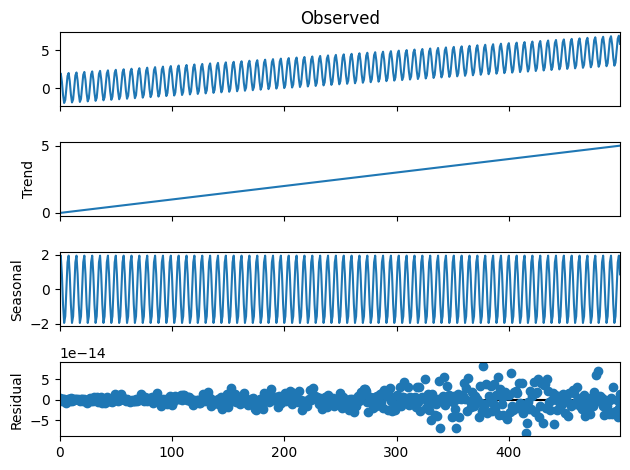

In [25]:
model = STL(endog=ts_obj, **study.best_params)

# default_stl_config['period'] = 2
# model = STL(endog=ts_obj, **default_stl_config)

# peaks, _ = find_peaks(x, height=0)
# peaks, _ = find_peaks(x, height=0)

result = model.fit()
result.plot()
plt.show()

In [26]:
# find_period_range(ts_obj,'mean'), find_period_range(ts_obj,'max')

## result estimation / saving result

In [ ]:
from typing import Callable, Any, Optional, Union
from abc import ABC, abstractmethod

class Decomp_Model(ABC):
    
    @abstractmethod
    def __init__(self, series, model_params):
        self.series = series
        self.model_params = model_params
    
    @abstractmethod
    def _init_model(self):
        """
        set up model to fit and predict
        """
        pass
    
    @abstractmethod
    def _fit(self):
        """
        fit on data
        """
        pass
    
    @abstractmethod
    def _infer(self, series):
        """
        make prediction and transform it into decomposition, estimated parameters, plots and feature vectors 
        
        4-dimensions, 4-spaces
        """
        pass


class Base_Optimizer(ABC):
    """
    -> (1) best params (2) opt pic
    """
    
    def __init__(self, series:np.ndarray, model:Decomp_Model, grid_params:dict, opt_func: Callable):
        
        self.series = series        
        self.model = model
        self.grid_params = grid_params
        
        # ... full без вызова
        
    def optimize(self, trial, fitted:bool=True):
        """
        
        """
        
        params = {}
        for param_name, config in self.param_grid.items():
            if config['type'] == 'categorical':
                params[param_name] = trial.suggest_categorical(param_name, config['values'])
            elif config['type'] == 'int':
                params[param_name] = trial.suggest_int(
                    param_name, config['low'], config['high'])
            elif config['type'] == 'float':
                params[param_name] = trial.suggest_float(
                    param_name, config['low'], config['high'],
                    log=config.get('log', False))

        self.model = self.model(**params)
        
        if fitted:
            self.model._fit()
        
        result = self.model._infer(self.series)
        
        return self.opt_func(result)

In [ ]:
class STL_Model(Decomp_Model):
    def __init__(self, series: np.ndarray, model_params: Dict[str, Any]):
        super().__init__(series, model_params)
        self._init_model()
        
    def _init_model(self):
        self.model = STL(self.series, **self.model_params)
        
    def _fit(self):
        pass        
    
    def _infer(self):
        result = self.model.fit()        
         
        return {
            'seasonal': result.seasonal,
            'trend': result.trend,
            'resid': result.resid,
            'period': self.model.period if self.model.period is not None else self.model_params['period'],
        }

class STL_Optimizer(Base_Optimizer):
    def __init__(self, series: np.ndarray, model: Decomp_Model, 
                 grid_params: Dict[str, Any], opt_func: Callable):
        self.series = series
        self.model = model
        self.grid_params = grid_params
        self.opt_func = opt_func
        
    def find_optimal_values(self, trial):
        # Implement the optimization logic
        params = {}
        for param_name, config in self.grid_params.items():
            if config['type'] == 'categorical':
                params[param_name] = trial.suggest_categorical(param_name, config['values'])
            elif config['type'] == 'int':
                params[param_name] = trial.suggest_int(
                    param_name, config['low'], config['high'])
            elif config['type'] == 'float':
                params[param_name] = trial.suggest_float(
                    param_name, config['low'], config['high'],
                    log=config.get('log', False))

        self.model = STL_Model(self.series, params)
                
        result = self.model._infer()
        return self.opt_func(result)

In [29]:
# Load your data
dt1 = JSON_Handler(filepath='data/Synthetic_data/several_periods/gen_dt1.json')
inx = 5
print(dt1.data['meta'][inx])
ts_obj = np.asarray(dt1.data['data'][inx])

# Define parameter grid
grid_params = {
    'period': {'type': 'int', 'low': 2, 'high': 20},
    'trend_deg': {'type': 'int', 'low': 0, 'high': 1},
    'seasonal_deg': {'type': 'int', 'low': 0, 'high': 1}
}

# Create optimizer
optimizer = STL_Optimizer(
    series=ts_obj,
    model=STL_Model,
    grid_params=grid_params,
    opt_func=seasonal_strength
)

# Optimize
study = optuna.create_study(direction="maximize")

study.optimize(optimizer.find_optimal_values, n_trials=200, timeout=2)

trial = study.best_trial

print("Best function value: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

optuna.visualization.plot_optimization_history(study)

read data from data/Synthetic_data/several_periods/gen_dt1.json
{'filepath': None, 'data': {'seasonality_windows': [7, 24], 'amplitude_list': [2, 2], 'trend_slope': 0.01, 'noise_level': 0.0, 'length': 500, 'seed': 25}}
Best function value: 0.9506013969433905
Best hyperparameters: {'period': 7, 'trend_deg': 0, 'seasonal_deg': 1}


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error

accuracy_score([trial.params['period']], [7])

1.0

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error

def stl_implement_exp(result_path:Path, stl_grid:Optional[Union[YAML_Config, Path]], dataset:Optional[Union[JSON_Handler, Path]], opt_func_name:Literal['seasonal_corr', 'seasonal_str']):
    """
    Эксперимент на синтетике с известными значениями периодичности
    """
    # Load your data
    if isinstance(dataset, Path):
        dataset = JSON_Handler(filepath=dataset)
    
    if isinstance(stl_grid, Path):
        stl_grid = YAML_Config(filepath=stl_grid).data
    
    # 
    opt_funcs = {
        'seasonal_corr':seasonal_correlation,
        'seasonal_str':seasonal_strength
    }
    
    # log results
    metrics = {
        'accuracy':[],
        'rmse_residual_plus':[],
        'rmse_residual_minus':[]
    }
    
    est_params = {
        'best_stl_val':[],
        'best_stl_params':[]
    }
    
    for inx, time_series in enumerate(dataset.data['data']):

        ts_obj = np.asarray(time_series)

        # Create optimizer
        optimizer = STL_Optimizer(
            series=ts_obj,
            model=STL_Model,
            grid_params=stl_grid,
            opt_func=opt_funcs[opt_func_name]
        )

        # Optimize
        study = optuna.create_study(direction="maximize")
        study.optimize(optimizer.find_optimal_values, n_trials=200 if opt_func_name == 'seasonal_corr' else 30, timeout=20)
        trial = study.best_trial


        est_params['best_stl_val'].append(trial.value)
        est_params['best_stl_params'].append(trial.params)
        
        pic_path = result_path/"pics/"
        pic_path.mkdir(parents=True, exist_ok=True)
        fig = optuna.visualization.plot_optimization_history(study)
        fig.write_html(pic_path/f"row_{inx}.html")
        
        metrics['accuracy'].append(np.max([accuracy_score(lbl if isinstance(lbl, list) else [lbl], [trial.params['period']]) for lbl in dt1.data['labels'][inx]]))
        
        model = STL_Model(time_series, trial.params)
        result = model._infer()
        
        metrics['rmse_residual_plus'].append(np.round(root_mean_squared_error(time_series, np.asarray(result['trend']) + np.asarray(result['seasonal']) + np.asarray(result['resid'])), 4))
        metrics['rmse_residual_minus'].append(np.round(root_mean_squared_error(time_series, np.asarray(result['trend']) + np.asarray(result['seasonal'])), 4))
        
        
        plot_series([time_series, np.asarray(result['trend']) + np.asarray(result['seasonal']) + np.asarray(result['resid'])], ['Original', 'Estimated'], save_path=pic_path/f"estimated/pic_{inx}_with_residual.png")
        plot_series([time_series, np.asarray(result['trend']) + np.asarray(result['seasonal'])], ['Original', 'Estimated'], save_path=pic_path/f"estimated/pic_{inx}_without_residual.png")
        
    metrics_avg = {}
    for k,v in metrics.items():
        metrics_avg [k+'_mean'] = np.mean(v).round(4)    
    metrics.update(metrics_avg)

    return metrics, est_params, stl_grid, dataset, pic_path

In [32]:
RESULT_PATH = Path(".temp/stl_synth_1/run_1/")
STL_GRID_PATH = Path('patrec/feature_extraction/stats_methods/configs/STL_grid.yaml')
DATASET_PATH = Path('data/Synthetic_data/several_periods/gen_dt1.json')

metrics, est_params, stl_grid, dataset, pic_path = stl_implement_exp(RESULT_PATH, STL_GRID_PATH, DATASET_PATH, 'seasonal_str')

read data from data/Synthetic_data/several_periods/gen_dt1.json


In [51]:
# YAML_Config('.temp/stl_synth_1/test.yaml')
# JSON_Handler('.temp/stl_synth_1/test.json')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error

def stl_implement_exp(result_path:Path, stl_grid:Optional[Union[YAML_Config, Path]], dataset:Optional[Union[JSON_Handler, Path]], opt_func_name:Literal['seasonal_corr', 'seasonal_str']):
    """
    Эксперимент на синтетике с известными значениями периодичности
    """
    # Load your data
    if isinstance(dataset, Path):
        dataset = JSON_Handler(filepath=dataset)
    
    if isinstance(stl_grid, Path):
        stl_grid = YAML_Config(filepath=stl_grid).data
    
    # 
    opt_funcs = {
        'seasonal_corr':seasonal_correlation,
        'seasonal_str':seasonal_strength
    }
    
    # log results
    metrics = {
        'accuracy':[],
        'rmse_residual_plus':[],
        'rmse_residual_minus':[]
    }
    
    est_params = {
        'best_stl_val':[],
        'best_stl_params':[]
    }
    
    for inx, time_series in enumerate(dataset.data['data']):

        ts_obj = np.asarray(time_series)

        stl_grid['period']['low'] = find_period_range(time_series, 'min') 
        stl_grid['period']['low'] = stl_grid['period']['low'] if stl_grid['period']['low'] > 1 else 2
        stl_grid['period']['high'] = find_period_range(time_series, 'mean')

        # Create optimizer
        optimizer = STL_Optimizer(
            series=ts_obj,
            model=STL_Model,
            grid_params=stl_grid,
            opt_func=opt_funcs[opt_func_name]
        )

        # Optimize
        study = optuna.create_study(direction="maximize")
        study.optimize(optimizer.find_optimal_values, n_trials=200 if opt_func_name == 'seasonal_corr' else 30, timeout=20)
        trial = study.best_trial


        est_params['best_stl_val'].append(trial.value)
        est_params['best_stl_params'].append(trial.params)
        
        pic_path = result_path/"plots/"
        pic_path.mkdir(parents=True, exist_ok=True)
        fig = optuna.visualization.plot_optimization_history(study)
        fig.write_html(pic_path/f"row_{inx}.html")
        
        metrics['accuracy'].append(np.max([accuracy_score(lbl if isinstance(lbl, list) else [lbl], [trial.params['period']]) for lbl in dt1.data['labels'][inx]]))
        
        model = STL_Model(time_series, trial.params)
        result = model._infer()
        
        metrics['rmse_residual_plus'].append(np.round(root_mean_squared_error(time_series, np.asarray(result['trend']) + np.asarray(result['seasonal']) + np.asarray(result['resid'])), 4))
        metrics['rmse_residual_minus'].append(np.round(root_mean_squared_error(time_series, np.asarray(result['trend']) + np.asarray(result['seasonal'])), 4))
        
        plot_series([time_series, np.asarray(result['trend']) + np.asarray(result['seasonal']) + np.asarray(result['resid'])], ['Original', 'Estimated'], save_path=pic_path/f"estimated/pic_{inx}_with_residual.png")
        plot_series([time_series, np.asarray(result['trend']) + np.asarray(result['seasonal'])], ['Original', 'Estimated'], save_path=pic_path/f"estimated/pic_{inx}_without_residual.png")
    
    metrics_avg = {}
    for k,v in metrics.items():
        metrics_avg [k+'_mean'] = np.mean(v).round(4)
        
    return [metrics, metrics_avg], est_params, stl_grid, dataset, pic_path

In [ ]:
# 2 
RESULT_PATH = Path(".temp/stl_synth_1/run_2/")
STL_GRID_PATH = Path('patrec/feature_extraction/stats_methods/configs/STL_grid.yaml')
DATASET_PATH = Path('data/Synthetic_data/several_periods/gen_dt1.json')

metrics, est_params, stl_grid, dataset, pic_path = stl_implement_exp(RESULT_PATH, STL_GRID_PATH, DATASET_PATH, 'seasonal_str')

## logging

In [33]:
from patrec.utils.mlflow_exp import MLflow_Experiment_Logger
import mlflow 

# Initialize logger with experiment name and optional tags
logger = MLflow_Experiment_Logger(
    experiment_name="basic_stl",
    tags={
        "project": "stats_model",
        "team": "i1",
        "version": "0.0.1"
    },
    # run_name="synthetic_data_grid_min_mean_3"
    run_name="synthetic_data_grid_min_max",
    temp_path=RESULT_PATH
)

logger.log_parameters(stl_grid)
logger.log_metrics(metrics)
logger.log_plots(pic_path)
logger.log_dataset(dataset.data)
logger.log_estimator_params(est_params)

save data to .temp/stl_synth_1/run_1/params.json
save data to .temp/stl_synth_1/run_1/metrics.json
save data to .temp/stl_synth_1/run_1/dataset.json
save data to .temp/stl_synth_1/run_1/est_params.json


In [34]:
logger._end_run()

🏃 View run synthetic_data_grid_min_max at: http://localhost:5000/#/experiments/871207913661856752/runs/cb4916e81a5443d598860f61944d7f0a
🧪 View experiment at: http://localhost:5000/#/experiments/871207913661856752


# Statistics test

In [ ]:
# seasonality and trend opt func
from typing import Literal
from scipy import stats
from scipy.stats import (pearsonr, spearmanr, kendalltau, 
                         pointbiserialr, weightedtau)
from scipy.spatial.distance import cosine


def seasonal_correlation(seasonal_component, algo:Literal['dist', 'prototype']='dist', params:dict=None):
    """
    Estimate correlation between seasonal component and ideal signal
    Optimize: maximization
    Intervals: 
        good (0.3, 1]
        suspicious: [-0.3, 0.3]
        bad: (-0.3, -1]
    """
    
    # can be expanded with generators    
    if params:
        t = params.get('t', np.arange(len(seasonal_component)))
        seasonal_period = params.get('seasonal_period', 12)
        ideal_signal = np.sin(2 * np.pi * t / seasonal_period)
    
    corr, _ = pearsonr(seasonal_component, ideal_signal)
        
    return corr

# from statsmodels.stats.dist_dependence_measures import distance_correlation, distance_statistics

# distance_correlation(data1, data2), distance_correlation(data1, data1)

def seasonal_strength(seasonal_component, residuals):
    """
    Estimate how greate changes in seasonal component and residuals
    Optimize: maximization
    Intervals: 
        good: [0.7, 1]
        sus: [0.3, 0.7)
        bad: [0, 0.3)
    """
    return max(0, 1 - np.var(residuals) / np.var(seasonal_component + residuals))

def trend_strength(trend_component, residuals):
    """
    Estimate how greate changes in trend component and residuals
    Optimize: maximization
    Intervals: 
        good: [0.7, 1]
        sus: [0.3, 0.7)
        bad: [0, 0.3)
    """
    return max(0, 1 - np.var(residuals) / np.var(trend_component + residuals))

# seasonal_correlation(result.seasonal, 'dist', {'seasonal_component':model.period}), seasonal_strength(result.seasonal, result.resid), trend_strength(result.seasonal, result.resid)

In [ ]:
# residuals opt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.descriptivestats import describe
from statsmodels.robust import mad

def residual_autocorrelation(residuals, nlags=5):
    """
    Sum of absolute residual ACF 
    optimize: minimize
    Interval: closer to 0 = better
    """
    acf_values = acf(residuals, nlags=nlags, fft=False)[1:]  # Exclude lag 0
    return np.sum(np.abs(acf_values))

def durbin_watson_test(residuals):
    """ 
    Тест Дарбина-Уотсона используется для проверки автокорреляции остатков.
    
    Значение теста варьируется от 0 до 4:
        2 указывает на отсутствие автокорреляции.
        Значения меньше 2 указывают на положительную автокорреляцию.
        Значения больше 2 указывают на отрицательную автокорреляцию.
    В общем, значения около 0 и 4 указывают на наличие проблемы с автокорреляцией.
    """
    return durbin_watson(residuals)

def residual_normality(residuals):
    """
    Shapiro-Wilk test for normality (p-value > 0.05 = normal)
        Если p-значение меньше 0.05, это указывает на то, что остатки не имеют нормального распределения.
        В таком случае можно использовать методы, не требующие нормальности остатков, или трансформации зависимой переменной, чтобы улучшить нормальность.

    """
    statistics, p_value = shapiro(residuals)
    return statistics, p_value


def shapiro_test(residuals):
    """
    Интерпретация результатов:
    Если p-значение меньше 0.05, это указывает на то, что остатки не имеют нормального распределения.
    В таком случае можно использовать методы, не требующие нормальности остатков, или трансформации зависимой переменной, чтобы улучшить нормальность.
    source - https://colab.research.google.com/github/CodeHunterOfficial/A_PythonLibraries/blob/main/Библиотека_Statsmodels.ipynb
    """
    result = stats.shapiro(residuals)
    return result.pvalue, result.statistic 


def classify_outliers_mad(residuals, threshold=3.5):
    """
    Categorizes outlier contamination using MAD scores
    
    Returns:
    -------
    dict: {
        'category': 'good'/'suspicious'/'bad',
        'outlier_indices': array,
        'outlier_ratio': float,
        'max_mad_score': float
    }
    """
    median = np.median(residuals)
    mad_val = mad(residuals, c=1)  # Consistency factor for normal dist
    
    # Calculate modified Z-scores
    mad_scores = 0.6745 * (residuals - median) / mad_val
    
    # Identify outliers
    outliers = np.abs(mad_scores) > threshold
    outlier_ratio = np.mean(outliers)
    max_mad = np.max(np.abs(mad_scores[outliers])) if any(outliers) else 0
    
    # Classification logic
    if outlier_ratio == 0:
        category = "good"
    elif outlier_ratio <= 0.05:  # <5% outliers
        if max_mad < 5:
            category = "good"
        else:
            category = "suspicious"
    elif outlier_ratio <= 0.15:  # 5-15% outliers
        category = "suspicious"
    else:
        category = "bad"
    
    return outlier_ratio, {
        'category': category,
        'outlier_indices': np.where(outliers)[0],
        'outlier_ratio': outlier_ratio,
        'max_mad_score': max_mad
    }


# STL

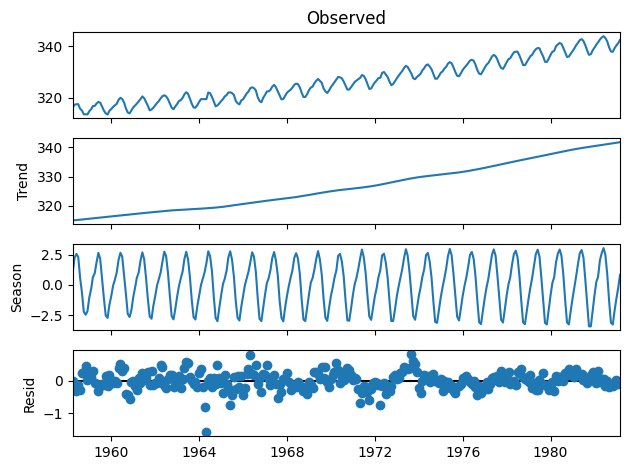

24
0.6029324566388982 0.9811530546258117 0.9811530546258117
1.0273402126735334 1.0861878979860173 (0.961431251585121, 3.827070249234413e-07) (0.0033333333333333335, {'category': 'suspicious', 'outlier_indices': array([73]), 'outlier_ratio': 0.0033333333333333335, 'max_mad_score': 6.6619195352048015})


In [ ]:
from statsmodels.tsa.seasonal import STL, MSTL

model = STL(data[:300], period=24)
result = model.fit()
result.plot()
plt.show()

print(model.period)

print(seasonal_correlation(result.seasonal, 'dist', {'seasonal_component':model.period}), seasonal_strength(result.seasonal, result.resid), trend_strength(result.seasonal, result.resid))

print(durbin_watson_test(result.resid), residual_autocorrelation(result.resid), residual_normality(result.resid),  classify_outliers_mad(result.resid))


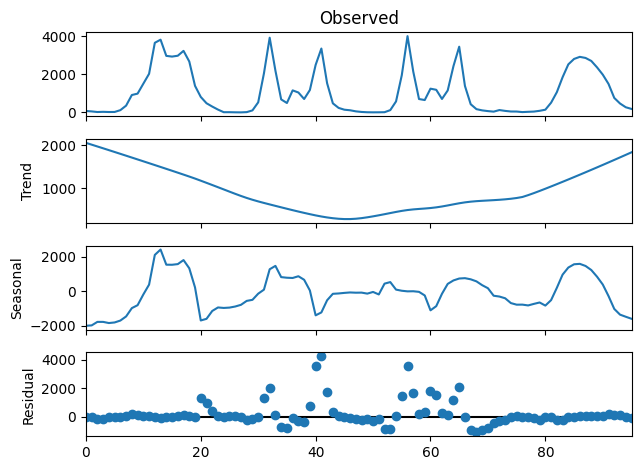

0.10513964311593342 0.48892174911367114 0.48892174911367114
0.6640267380408347 0.8919418315632838 (0.7079700935223157, 1.5931042215604887e-12) (0.23958333333333334, {'category': 'bad', 'outlier_indices': array([20, 21, 31, 32, 34, 35, 39, 40, 41, 42, 52, 53, 55, 56, 57, 60, 61,
       64, 65, 67, 68, 69, 70]), 'outlier_ratio': 0.23958333333333334, 'max_mad_score': 23.01016003606592})


In [145]:
params = {
    'period': 20, 
    'trend_deg': 1, 
    'seasonal_deg': 1,
    'robust': True
}

model = STL(endog=row1, **params)
result = model.fit()
result.plot()
plt.show()

print(seasonal_correlation(result.seasonal, 'dist', {'seasonal_component':model.period}), seasonal_strength(result.seasonal, result.resid), trend_strength(result.seasonal, result.resid))

print(durbin_watson_test(result.resid), residual_autocorrelation(result.resid), residual_normality(result.resid), classify_outliers_mad(result.resid)
)


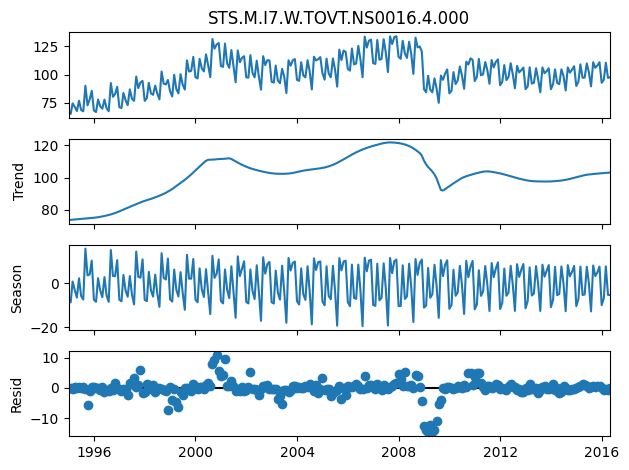

-0.3153213350422851 0.8900785683259608 0.8900785683259608
0.5133449172999075 2.566165593408054 (0.7296142897797591, 3.5709699756320575e-20) (0.14785992217898833, {'category': 'suspicious', 'outlier_indices': array([  9,  34,  47,  49,  51,  52,  68,  69,  70,  71,  72,  73,  74,
        86,  99, 101, 120, 129, 140, 156, 159, 164, 165, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 189, 190, 192, 193, 194]), 'outlier_ratio': 0.14785992217898833, 'max_mad_score': 15.492661392033032})


In [146]:
from statsmodels.datasets import elec_equip as ds

elec_equip = ds.load().data.iloc[:, 0]

model = STL(endog=elec_equip, period=12, robust=True)
result = model.fit()
result.plot()
plt.show()

print(seasonal_correlation(result.seasonal, 'dist', {'seasonal_component':model.period}), seasonal_strength(result.seasonal, result.resid), trend_strength(result.seasonal, result.resid))

print(durbin_watson_test(result.resid), residual_autocorrelation(result.resid), residual_normality(result.resid), classify_outliers_mad(result.resid)
)



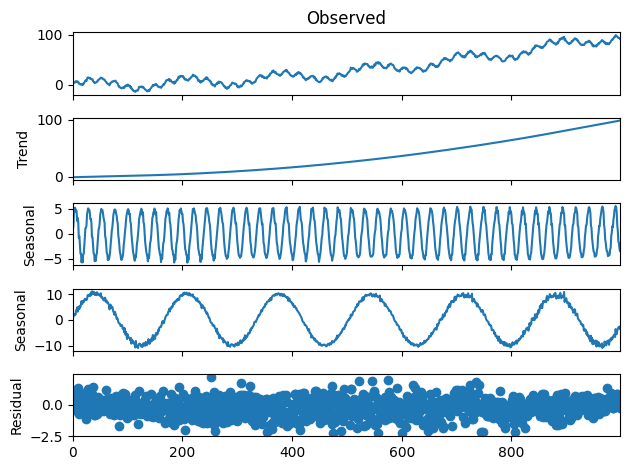

In [15]:
import pandas as pd

t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
noise = np.random.randn(len(t))
y = trend + daily_seasonality + weekly_seasonality + noise
# ts = pd.date_range(start="2020-01-01", freq="h", periods=len(t))
# df = pd.DataFrame(data=y, index=ts, columns=["y"])

params = {
    # 'periods': [48, 48*7],
    'periods': [24, 24 * 7],
    # 'windows':[101, 101],
    # 'iterate':3,
    # "stl_kwargs":{
    #             "trend":1001, # Setting this large will force the trend to be smoother.
    #             "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
    #            }
}

model = MSTL(endog=y, **params)
result = model.fit()
fig = result.plot()
plt.show()

# print(seasonal_correlation(result.seasonal, 'dist', {'seasonal_component':model.period}), seasonal_strength(result.seasonal, result.resid), trend_strength(result.seasonal, result.resid))

# print(durbin_watson_test(result.resid), residual_autocorrelation(result.resid), residual_normality(result.resid), classify_outliers_mad(result.resid)
# )

# plot_series([trend, daily_seasonality, weekly_seasonality, noise])

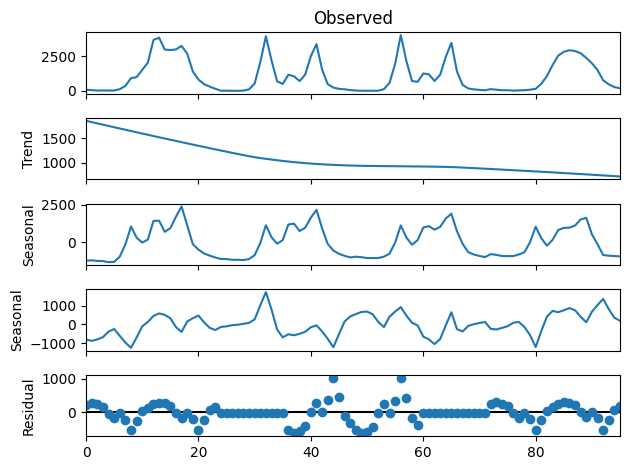

In [97]:
params = {
    # 'periods': [48, 48*7],
    # 'periods': [12, 24, 24*7],
    'periods': [24, 36],
    # 'windows':[101, 101],
    # 'iterate':3,
    # "stl_kwargs":{
    #             "trend":1001, # Setting this large will force the trend to be smoother.
    #             "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
    #            }
}

# model = MSTL(endog=synth_row1, **params)
model = MSTL(endog=row1, **params)
result = model.fit()
fig = result.plot()

In [98]:
# plot_series(result.seasonal[:,0])


print(seasonal_correlation(result.seasonal[:,0], 'dist', {'seasonal_component':model.periods[0]}), seasonal_strength(result.seasonal[:,0], result.resid), trend_strength(result.seasonal[:,0], result.resid))

print(durbin_watson_test(result.resid), residual_autocorrelation(result.resid), residual_normality(result.resid), classify_outliers_mad(result.resid)
)




0.12731977100527786 0.9198374436695357 0.9198374436695357
0.6791550007567668 1.5680348980962926 (0.9191757726919416, 1.8459666809230134e-05) (0.020833333333333332, {'category': 'good', 'outlier_indices': array([44, 56]), 'outlier_ratio': 0.020833333333333332, 'max_mad_score': 4.268189063546576})


# Clad code

8 96 12


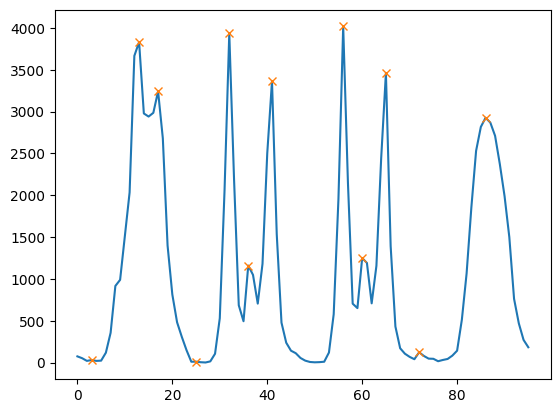

In [ ]:


def find_period_range(series, strategy:Literal['mean', 'max']='max', ci_coef:int=2):
    
       
    if strategy == 'mean':
        peaks, _ = find_peaks(series, height=0)
        ci_coef = 1/ci_coef
        return int(np.mean(peaks - np.concatenate([np.array([0]), peaks[0:]])[:-1]) * ci_coef), peaks
    
    if strategy == 'min':
        peaks, _ = find_peaks(series, height=-np.abs(np.max(series)))
        return int(np.min(peaks - np.concatenate([np.array([0]), peaks[0:]])[:-1])), peaks
    
    peaks, _ = find_peaks(series, height=np.median(series))

    return int(np.max(peaks - np.concatenate([np.array([0]), peaks[0:]])[:-1]) * ci_coef), peaks




c, peaks = find_period_range(ts_obj,'min')

print(int(len(ts_obj) / len(peaks)), len(ts_obj) , len(peaks))

plt.plot(ts_obj)
plt.plot(peaks, ts_obj[peaks], "x")
plt.show()

[32]


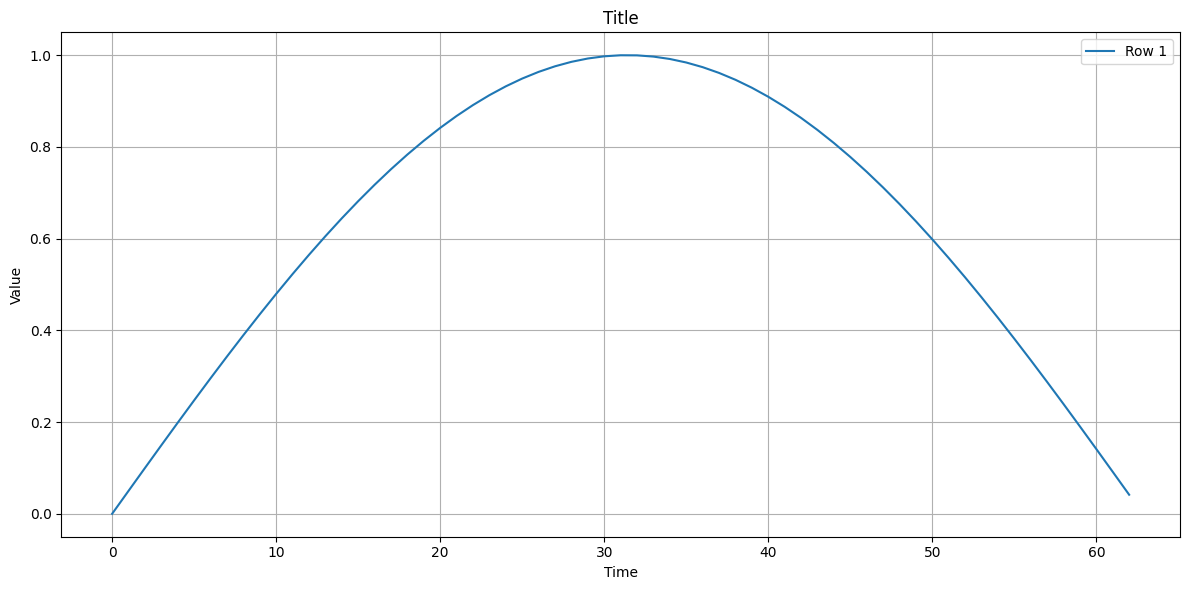

In [ ]:
import numpy as np
from scipy import signal
xs = np.arange(0, np.pi, 0.05)
data = np.sin(xs)
peakind = signal.find_peaks_cwt(data, np.arange(1,10))
peakind, xs[peakind], data[peakind]

print(peakind)
plot_series(data)

Theil-Sen slope: 0.486
OLS slope: 0.380


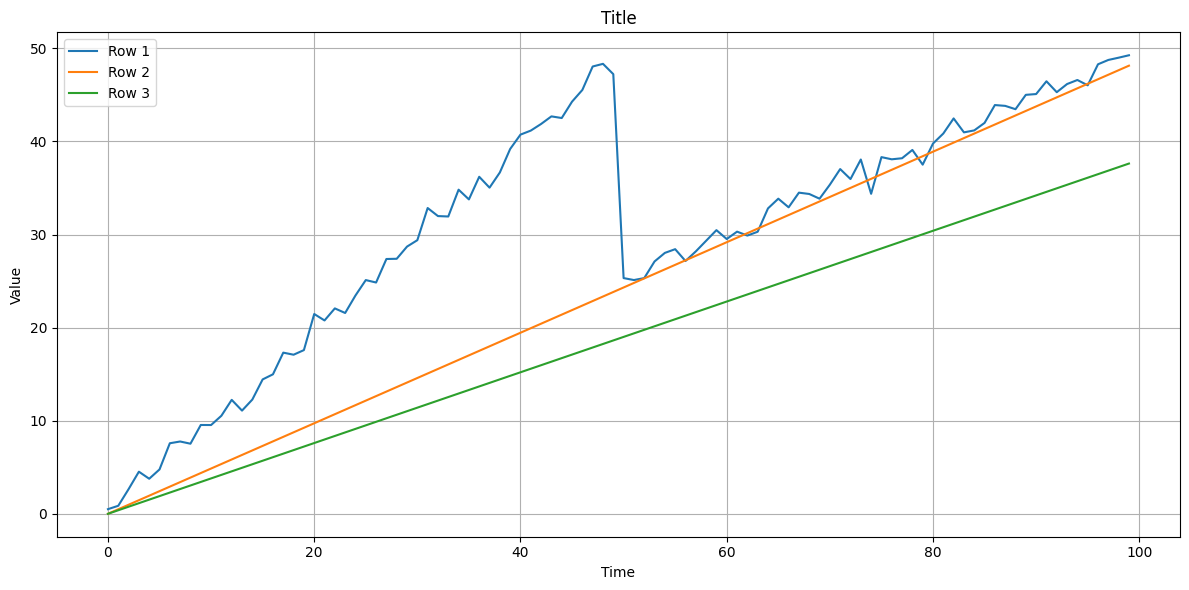

In [ ]:
from sklearn.linear_model import TheilSenRegressor

X = np.arange(len(y)).reshape(-1, 1)
model = TheilSenRegressor().fit(X, y)

print(f"Theil-Sen slope: {model.coef_[0]:.3f}")

# Compare with OLS
ols_slope = sm.OLS(y, sm.add_constant(X)).fit().params[1]
print(f"OLS slope: {ols_slope:.3f}")

plot_series([y, X*model.coef_[0], X*ols_slope])

In [ ]:
import pymc as pm
import arviz as az

# Generate data with two changepoints
np.random.seed(42)
y = np.concatenate([
    np.random.randn(50),
    np.random.randn(50) + 5,
    np.random.randn(50) - 3
])

# Bayesian changepoint detection
with pm.Model() as model:
    # Priors for changepoints (uniform over time)
    tau1 = pm.DiscreteUniform("tau1", lower=10, upper=80)
    tau2 = pm.DiscreteUniform("tau2", lower=tau1 + 10, upper=90)
    
    # Segment means
    mu1 = pm.Normal("mu1", mu=0, sigma=10)
    mu2 = pm.Normal("mu2", mu=0, sigma=10)
    mu3 = pm.Normal("mu3", mu=0, sigma=10)
    
    # Likelihood
    y_obs = pm.Normal(
        "y_obs",
        mu=pm.math.switch(pm.math.le(np.arange(150), tau1), mu1,
                          pm.math.switch(pm.math.le(np.arange(150), tau2), mu2, mu3)),
        sigma=1,
        observed=y
    )
    
    trace = pm.sample(1000, tune=1000)

# Plot changepoints
az.plot_trace(trace, var_names=["tau1", "tau2"])
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau1]
>>Metropolis: [tau2]
>NUTS: [mu1, mu2, mu3]


Output()

TypeError: string indices must be integers, not 'str'